<a href="https://colab.research.google.com/github/dvpaa/Hands-on-Machine-Learning/blob/main/3%EC%9E%A5_%EB%B6%84%EB%A5%98_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. 설정 

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1.MNIST

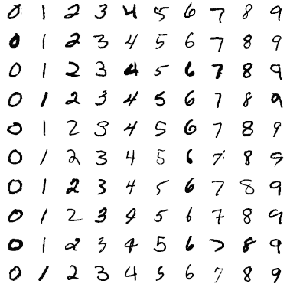


MNIST 데이터셋은 위와 같이 다수의 사람들이 수기로 작성한 숫자 이미지들를 모은것이다.

MNIST 데이터셋을 받는 법

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

시작하기 앞서 MNIST 데이터 셋을 "특성들로만 이루어진 데이터 셋" 과 "target 값들로만 이루어진 데이터 셋" 으로 분리한다.

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape




(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
28 * 28

784

그림 저장: some_digit_plot


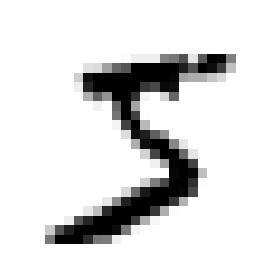

'5'

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()
y[0]

In [7]:
y = y.astype(np.uint8)

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [9]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장: more_digits_plot


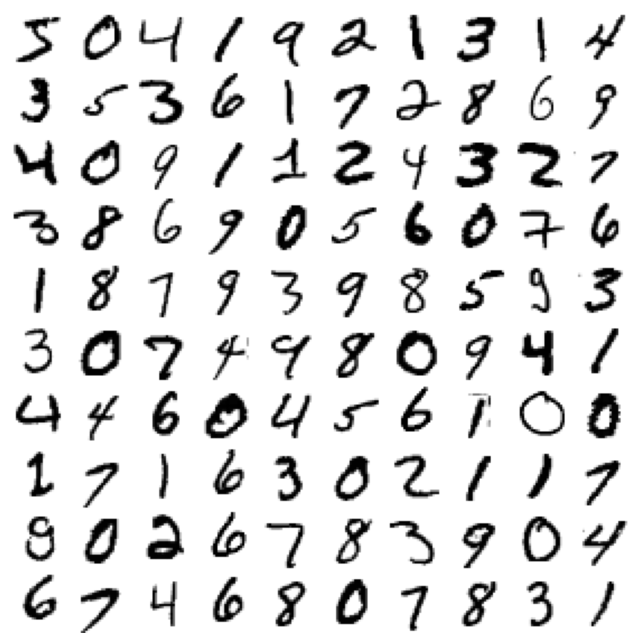

5

In [10]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()
y[0]

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

##2. 이진 분류기 훈련 (binary classifier)

- 확률적 경사 하강법 분류기(SGDClassifier)
  - 매우 큰 데이터 셋을 효율적으류 처리하는 장점이 있다.
    : 한번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문에

- 사이킷런은 SGDClassifier 클래스를 사용하면 된다.
  - SGDClassifier는 훈련하는 데 무작위성을 사용한다.
  - 따라서 random_state 매개변수를 지정해주는 것이 좋다. 
  
  

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

분류기는  이 이미지가 5를 나탄낸다고 추측했다 (TRUE)

# **3. 성능측정**

### **i. 교차 검증을 사용한 정확도 측정**
   
   cross_val_score()함수 사용

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- 정확도 (Accuracy)
  - 정확하게 예측한 비율
  - 하지만 정확도의 분류기의 성능 측정 지표로 선호하지는 않는다. 
  
    -> 불균형 데이터 셋의 경우, 클래스 치우침 현상때문에 정확도가 무조건 높게 나오게 된다.






### **ii. 오차 행렬(Confusion Matrix)**
  -  오차 행렬을 만들려면 실제 target과 비교할 수 있도록 먼저 예측값을 만들어주어야 한다.
  -  cross_val_predict() 함수를 사용하면 k-fold 교차 검증을 수행하지만, 평가 점수가 아닌 각 테스트 fold에서 얻은 예측을 반환한다.



In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

confusion_matrix() 함수를 사용해 오차행렬을 만들 준비가 되었다. 타킷클래스(t_train_5)와 예측 클래스(y_traind_pred)를 넣고 호출한다.

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차행렬에서

    행: 살제클래스
    열: 예측한 클래스
  
  - 첫 번째 행은 '5 아님' 이미지(negative class) 에 대한 것으로, 53,892개를 ' 5 아님'으로 정확하게 분류 (true negative) 했고 나머지는 687개는 '5'라고 잘목 분류(false posotove) 했다.
  - 두 번째 행은 '5' 이미지(positive class)에 대한 것으로, 1,891개를 '5 아님'으로 잘못 분류(false negative)했고  나머지 3,530개를 정확히 '5'라고 분류(true positive) 했다.

### **iii. 정밀도(Precision)와 재현율(Recall)**
- 오차행렬이 많은 정보를 제공해주지만, 가끔 더 요약된 지표가 필요할 때도 있다.
- 이럴 경우 사용하는 지표가 바로 **정밀도** 와 **재현율** 이다.

  - **정밀도(Precision)**: 모델이 True 라고 분류한 것 중에서 실제 True인 것의 비율
  - **재현율(Recall)**: 실제 True 인것 중에서 모델이 True라고 예측반 것의 비율(민감도라고도 한다.)

  :정밀도와 재현율을 성능 측정지표로 같이 사용하는 것이 일반적이다.



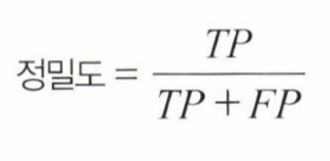




- True Positive(TP) : 실제 True인 정답을 True라고 예측(정답)
- False Positive(FP) : 실제 False인 정답을 True라고 예측(오답)
- False Negative(FN) : 실제 True인 정답을 False라고 예측(오답)
- True Negative(TN) : 실제 False인 정답을 False라고 예측(정답)

### **iiii. F1 점수(F1 Score)**

  - F1 Score는 정밀도와 재현율의 조화 평균이다.
  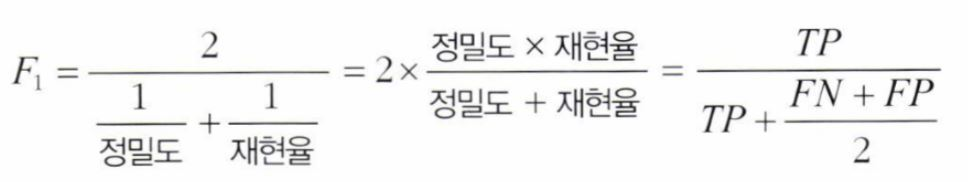

- 정밀도와 재현율이 비슷한 분류기에서는 F1 score 값이 높다.
- 하지만 F1 score가 항상 Best 성능 지표
- 상황에 따라 정밀도가 중요할 수 있고, 재현율이 중요할 수도 있다.
    - ex) 재현율(혹은 민감도)가 중요한 경우: 악성 종양 분류

      : 종양을 검사라는데 악성 종양을 양성이라고 판단하면, 그 환자는 치료할 기회를 놓치게 되고 목숨까지 위험해진다. 반대로 양성 종양을 악성이라고 판단하면 환자가 불필요한 비용을 지뷸해진다.
    - ex) 정밀도가 중요한 경우: 스팸메일 분류

      : 수신 받은 메일이 정상 메일임에도 불구하고 스팸메일로 판단하면, 정말로 중요한 메일을 받지 못하는 상황이 발생한다. 반면에 수신 받은 메일이 스팸메일임에도 불구하고 정상 메일로 판단하면, 비록 스팸메일을 받게 되는 불편함은 있지만 중요한 메일을 받지못할 상황은 면할 수 있다. 

In [18]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

F1 점수를 계산하려면 f1_score() 함수를 호출하면 된다.


In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846




### **iiiii. 정밀도/ 재현율 Trade-Off**

- 정밀도 와 재현율 사이에는 다음과 같은 관계가 성립한다.
  - 임곗값을 높이면 정밀도가 높아지지만 제현율은 낮아지고, 임곗값을 낮추면 재현율은 높아지지만 정밀도가 낮아진다.
  - 이해를 돕기 위해 MNIST 데이터 셋을 예시로 첨부하였다.
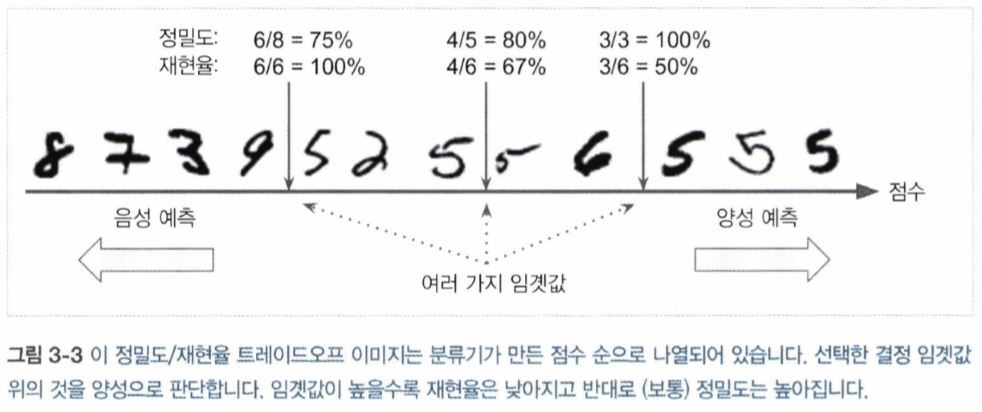

- 정밀도와 재현율을 동시에 높은값으로 얻을 수는 없으며, 이러한 현상은 정밀도/재현율 트레이드 오프라고 한다.

- 적절한 임곗값(threshold)을 어떻게 정하는 법은?

  - 먼저 cross_val_predict() 함수를 사용해서 훈련데이터 셋에 있는 모든 샘플의 점수를 구해야 한다.
    - 단, 주의할 점은 예측 결과를 반횐받는 것이 아니라 결정 점수를 반환받도록 지정해야 한다.

    - 그리고 반환 받은 결정 점수로 precision_recall_curve() 함수를 사용하여, 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산하다. 정밀도와 재현율은 matpotlib을 사용해서 그려본다.

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율을 그릴 수 있다.

그림 저장: precision_recall_vs_threshold_plot


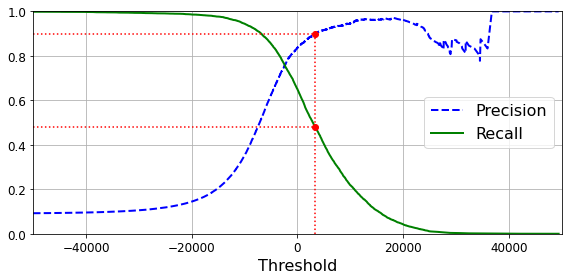

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

- 정밀도 곡선이 재현율 곡선보다 울퉁불퉁한 이유?

  -> 임곗값을 올리더라도 정밀도가 가끔 낮아진는 경우가 있기 때문이다.(일반적으로는 높아져야 한다) 

재현율에 대한 정밀도 곡선을 그려보면 좋은 정밀도/재현율 Trade-off를 선택할 수 잇다.

그림 저장: precision_vs_recall_plot


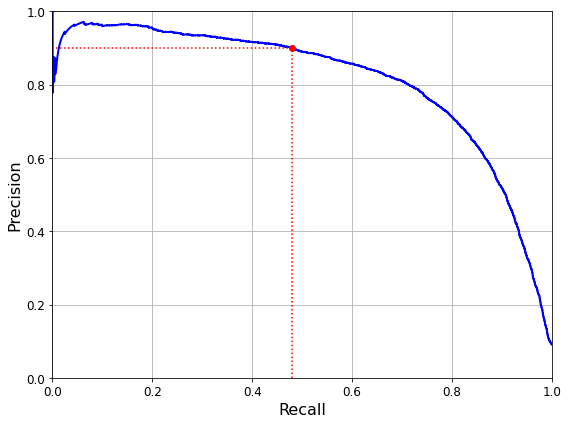

In [25]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

- 재현율 80% 근처에서 정밀도가 급격하게 하락
- 이러한 하강점 직적을 정밀도/ 재현율 Trade-Off로 선택하는 것이 좋다.
  - 위 곡선의 경우, 재현율이 60% 정도인 지점을 선택한다.

### **iiiiii. ROC곡선(ROC Curve)**

-  수산기 조작 특성(ROC) 곡선도 이진 분류에서 널리 사용하는 도구이다. 
- 거짓 양성 비율 false positive rate (FPR) 에 대한 진짜 양성 비율 true positive rate(TPR) 의 곡선이다.
  - 여기서 FPR은 양성으로 잘못 분륟힌 음성 샘플의 비율을 의미한다.
  - 즉, 1에서 음성으로 정확하게 분류딘 음성 샘플의 비율인 True Negative Rate(TNR)을 뺀값이다.
  - True Negative Rate(TNR)을 특이도(specificity)라고 한다.

- 따라서 ROC 곡선은 민감도(또는 재현율)에 대한 **(1-특이도)** 그래프라고 보면 된다.



In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


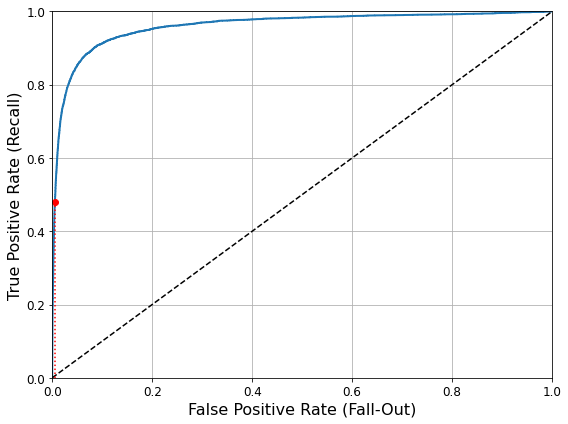

In [27]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성이 늘어난다. 

점선은 완전한 랜덤 분류가의 ROC곡선을 뜻한다. 

좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 한다. 


- AUC(Area Under the Curve)
  - AUC란 곡선 아래의 면적을 의미하며, 이 값을 사용하여 분류기의 성능을 측정할 수 있다. 
  - 완벽한 분류기는 ROC 곡선의 AUC가 1이고, 왼전한 랜덤 분류기란 훈련 데이터셋의 class 비율에 따라 무작위로 예측하는 것을 말한다. 

  -사이킷런의 roc_auc_score() 함수를 사용하면 쉽게 구할 수 있다. 

  - 일반적으로 양성 class가 드물거나 False Negative(FN)보다 False Positive(FP)가 더 중요할 때 (ex. 악성 종양 분류)는 PR곡선( 정밀도 - 재현율 곡선)을 사용하고, 그렇지 않으면 ROC 곡선을 사용한다.

# 4.다중 분류

- 이진 분류가 두 개의 클래를 구별하는 반면 다중분류기 multiclass classifier(또는 다항 분류기 multinomial classifier)는 둘 이상의 클래스를 구별할 수 있다. 

- 다중 분류 모델 
  - SGD(Stochastic Gardient Descent)
  - 랜덤포레스트
  - 나이브 베이즈

- 이진 분류 모델
  - 로지스틱 회귀
  - 서포트 벡터 머신
  - 등등


- 이진 분류기를 여러 개 사용해서 다중 class를 분류하는 기법
  1. OvR(one-versus-the Rest)또는 OvA(One-Versus-All) 전략
  - ex) 이미지를 분류할 때, 각 분류기의 결정 점수 중에 가장 높은 것을 class로 선택한다.
  - 대부분의 이진 분류 알고리즘에선ㄴ OvO보다 OvR을 선호한다.

  2.OvO(One-versus-One) 전략
  -ex) 0과 1 구별, 0과 2 구별 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시킨다.
  - 각 분류기의 훈련에 전체 훈련 데이터 셋 중, 구별할 두 class에 해당하는 샘플만 필요하다는 장점이 있다.
  - 특히 서포트 벡터 머신과 같이 훈련 데이트 세트의 크기에 민감한 모델인 경우, 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 데이터 셋에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO전략을 선호한다.

  - 다중 class 분류 작업에 이진 분류 알고리즘을 선택하면, 사이킷런이 알고리즘에 따라 자동으로 OvO 또는 OvO를 실행해준다.

In [29]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [30]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [31]:
np.argmax(some_digit_scores)

5

In [32]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [33]:
svm_clf.classes_[5]

5

In [34]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [35]:
len(ovr_clf.estimators_)

10

In [36]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

#5.에러분석

  - 가능성이 높은 모델을 하나 찾았다고 가정하고, 해당 모델의 성능을 높이기 위한 방법으로 에러분석이 있다.
  - 우선 **오차행렬(Confusion Matrix)**를 확인해 볼 수 있는데, 다음과 같이 matpotlib의 matshow() 함수를 사용해서 이미지로 표현하면 보기가 편리하다. 

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

- 다음으로 오차 행렬의 각 값을 대응되는 class의 이미지 개수를 나누어 에러 비율을 비교한다.
  - 에러의 절대 개수가 아닌 에러비율로 비교하는 이유는, 개수로 비교하면 이미지가 많은 class 가 상대적으로 나쁘게 보이기 때문이다.
  - 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 다시 그리면 다음과 같다.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

class 8의 열이 상당히 밝은데, 이는 많은 이미지가 8로 잘못 분류되었음을 암시한다. 하지만 class 8의 행은 그리 나쁘지 않은데, 이는 실제 8이 적절히 8로 분류되었다는 것을 말한다.

- 위와 같이 오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 insight를 얻을 수 있다

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

#6. 다중 레이블 분류
  - 분류기가 샘플마다 여러 개의 class를 출력하는 것이다. 
    -ex) 얼굴 인식 분류기 -> 같은 샂진에 여러 사람이 등장한다면? 인식된 사람마다 하나씩 꼬리표(tag)를 붙여야 한다.

  - 쉽게 말해, target label 값이 여러 개인 경우에 대해서 분류하는 것을 말한다.
  - 각각의 target label에 속한 샘플 수를 기반으로 가중치를 줄 수도 있다.



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

#7. 다중 출력 분류 (또는 다중 출력 다중 클래스 분류)
  - 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한 것이다.
  - 즉, 분류기의 출력이 다중 레이블이고 각 레이블은 값을 여러 개 갖는 경우를 말한다.
    - 즉 ex) 이미지 잡음 제거 시스템